In [88]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000) 
pd.set_option('display.max_colwidth', None)

In [46]:
script_dir = Path.cwd()

baseTablePath = script_dir.parent.parent/"data"/"analysis_base_clean.csv"
df = pd.read_csv(baseTablePath)

# df.dropna(inplace = True)

In [47]:
df['early_onset_proxy'] = df['age_years'].apply(lambda x: 1 if x <=50 else 0)
df.drop(columns=['bmx_weight_kg','bmx_height_cm','bmx_waist_cm','bmx_hip_cm','mcq220'], inplace = True)

In [48]:
vars_cont = ['age_years', 'pir', 'dpq_total', 'hscrp_mg_l_raw', 'bmx_bmi']
vars_cat  = [ 'smoke_status']

In [49]:
# df_pca = df[df['ever_cancer']==1]

df_pca = df[vars_cont + vars_cat].copy()
df_pca.dropna(inplace=True)
df_pca = pd.get_dummies(df_pca, columns=vars_cat, drop_first=True)

In [50]:
scaled = StandardScaler().fit_transform(df_pca)

In [51]:
from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(scaled)
explained = pca.explained_variance_ratio_

In [52]:
explained

array([0.26082896, 0.21228186, 0.16610707, 0.12358973, 0.10627516,
       0.0929566 , 0.03796062])

In [53]:
df_pca_final = pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(components.shape[1])])
df_pca_final['ever_cancer'] = df['ever_cancer']

In [54]:

ttest_ind(
    df_pca_final[df_pca_final['ever_cancer']==1]['PC1'],
    df_pca_final[df_pca_final['ever_cancer']==0]['PC1'],
    nan_policy='omit'
)

TtestResult(statistic=np.float64(-0.7287704204670394), pvalue=np.float64(0.4662015905384306), df=np.float64(2869.0))

In [58]:

X = df_pca_final[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']]
y = df_pca_final['ever_cancer']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.413727
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            ever_cancer   No. Observations:                 2871
Model:                          Logit   Df Residuals:                     2863
Method:                           MLE   Df Model:                            7
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                0.005989
Time:                        20:37:13   Log-Likelihood:                -1187.8
converged:                       True   LL-Null:                       -1195.0
Covariance Type:            nonrobust   LLR p-value:                   0.04587
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7788      0.054    -33.228      0.000      -1.884      -1.674
PC1           -0.0250      0.

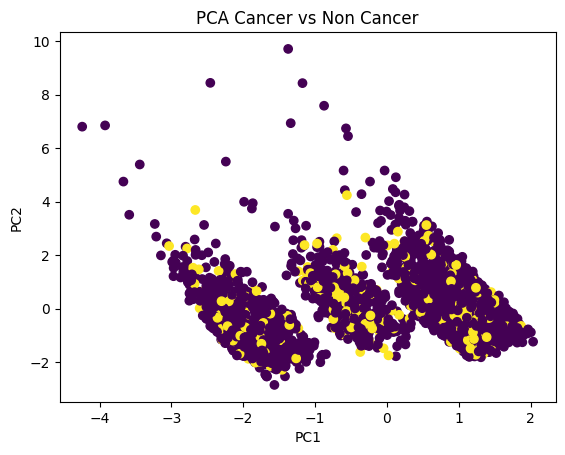

In [61]:
plt.scatter(df_pca_final['PC1'], df_pca_final['PC2'], c=df_pca_final['ever_cancer'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Cancer vs Non Cancer')
plt.show()

### Supervised Learning

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cont_vars = ['age_years', 'pir', 'dpq_total', 'hscrp_mg_l_raw', 'bmx_bmi']
cat_vars = ['sex', 'race_eth', 'educ_level', 'smoke_status']

X = df[cont_vars + cat_vars].copy()
y = df['ever_cancer']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_vars),
        ('num', StandardScaler(), cont_vars)
    ]
)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

brf_model = ImbPipeline(steps=[
    ('prep', preprocessor),
    ('brf', BalancedRandomForestClassifier(
        n_estimators=400,
        sampling_strategy='auto',
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42
    ))
])

In [89]:
brf_model.fit(X_train, y_train)
y_pred = brf_model.predict(X_test)
y_prob = brf_model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6574358974358975
F1 Score: 0.400359066427289
AUC: 0.7697206983161756

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76      1658
           1       0.27      0.76      0.40       292

    accuracy                           0.66      1950
   macro avg       0.61      0.70      0.58      1950
weighted avg       0.84      0.66      0.71      1950



#### Feature Importance

In [90]:
ohe = brf_model.named_steps['prep'].transformers_[0][1]
ohe_features = list(ohe.get_feature_names_out(cat_vars))

all_features = ohe_features + cont_vars
brf = brf_model.named_steps['brf']
importances = brf.feature_importances_

feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp)

                feature  importance
13            age_years    0.395607
14                  pir    0.129018
16       hscrp_mg_l_raw    0.124528
17              bmx_bmi    0.123095
15            dpq_total    0.061519
2          race_eth_3.0    0.033384
0                 sex_2    0.022472
10  smoke_status_former    0.021031
7        educ_level_4.0    0.015040
11   smoke_status_never    0.014310
6        educ_level_3.0    0.012578
8        educ_level_5.0    0.012494
4          race_eth_nan    0.009050
3          race_eth_4.0    0.008876
1          race_eth_2.0    0.008568
5        educ_level_2.0    0.007935
9        educ_level_nan    0.000312
12     smoke_status_nan    0.000181
